In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from copy import deepcopy
from collections import defaultdict

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []
dir = 'altered_pathways'
for experiment in list(os.listdir(dir)):
    if experiment == '.DS_Store': continue
    res_path = os.path.join(dir, experiment, 'results')
    res_file = open(res_path, 'rb')
    results = pickle.load(res_file)
    res_file.close()
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', results, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        

Specie:  auxin expected result:  unchanged  normal final:  38.60759493191339  altered final:  38.60759493191339
confidence interval:  [0.4778817909213799, 0.48033677743079833]
deltas coming from simulation:  [0.0, 0.0]
Specie:  TIR1 expected result:  unchanged  normal final:  14.450479084437017  altered final:  14.450479084437017
confidence interval:  [0.42525082374954853, 0.43425588215845856]
deltas coming from simulation:  [0.0, 0.0]
Specie:  auxinTIR1 expected result:  unchanged  normal final:  1.3730309949464363  altered final:  1.3730309949464363
confidence interval:  [0.388744644908035, 0.39713926371736147]
deltas coming from simulation:  [0.0, 0.0]
Specie:  auxinTIR1VENUS expected result:  unchanged  normal final:  2.63648992075444  altered final:  2.63648992075444
confidence interval:  [0.669753708948724, 0.6778951949229621]
deltas coming from simulation:  [0.0, 0.0]
Specie:  VENUS expected result:  unchanged  normal final:  7.789320649480276  altered final:  7.789320649480276


In [3]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  45  correct:  31  uncertain:  0  true pos:  16  true neg:  15  false_pos:  2 false neg:  2


In [4]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()

In [5]:
partial_results

{'total_species': 163,
 'uncertain_species': 3,
 'correct_species': 132,
 'true_positives': 67,
 'false_positives': 16,
 'false_negatives': 15,
 'true_negatives': 65}

In [2]:
description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
}

In [3]:
def convert_sbml_to_network(file_path):
    
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        if len(formula_splitted) >= 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])

In [4]:
convert_sbml_to_network('BIOMD0000000413.xml')

Errors occurred while loading the SBML file.
number reactions 9
number species 5


In [5]:
len(description['reactions'])

9

In [2]:
desc_path = '/home/depa/DataspellProjects/netProp/dataset/real_dataset/413/altered_pathways2/reaction0/description'
desc_file = open(desc_path, 'rb')
desc = pickle.load(desc_file)
desc_file.close()
desc

{'species': ['auxin', 'TIR1', 'auxinTIR1', 'auxinTIR1VENUS', 'VENUS'],
 'reactions': [['auxin_TIR1association', 0, 1],
  ['auxin_TIR1dissociation', 0, 1],
  ['auxin_TIR1_VENUSassociation', 0, 1],
  ['auxin_TIR1_VENUSdissociation', 0, 1],
  ['auxin_TIR1_VENUSdissociationleadingtoubiquitination', 0, 1],
  ['auxinproduction', 0, 1],
  ['auxindecay', 0, 1],
  ['VENUSproduction', 0, 1],
  ['VENUSphotobleachingdecay', 0, 1]],
 'connections': [['auxin', 'auxin_TIR1association'],
  ['TIR1', 'auxin_TIR1association'],
  ['auxin_TIR1association', 'auxinTIR1'],
  ['auxinTIR1', 'auxin_TIR1dissociation'],
  ['auxin_TIR1dissociation', 'auxin'],
  ['auxin_TIR1dissociation', 'TIR1'],
  ['auxinTIR1', 'auxin_TIR1_VENUSassociation'],
  ['VENUS', 'auxin_TIR1_VENUSassociation'],
  ['auxin_TIR1_VENUSassociation', 'auxinTIR1VENUS'],
  ['auxinTIR1VENUS', 'auxin_TIR1_VENUSdissociation'],
  ['auxin_TIR1_VENUSdissociation', 'auxinTIR1'],
  ['auxin_TIR1_VENUSdissociation', 'VENUS'],
  ['auxinTIR1VENUS', 'auxin_TIR

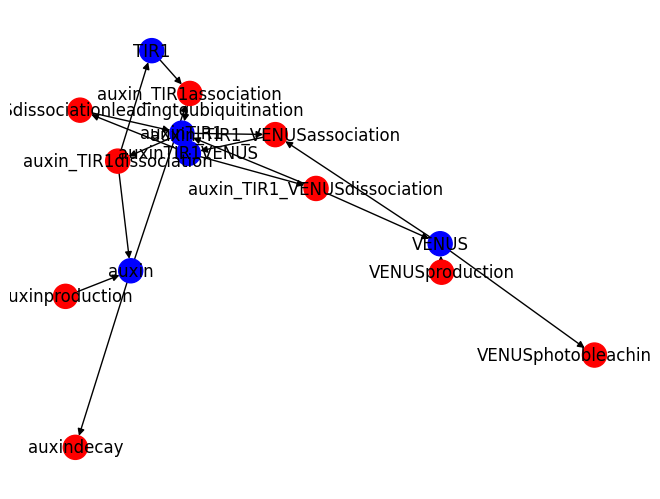

In [4]:
grap = functions.generate_graph(desc)
functions.plot_graph(grap)

In [5]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [6]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        print('Considering reaction: ', reaction.getId(), ' value of i: ', i)
        
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            print('altering: ', description['reactions'][i][0], ' from sbml: ', reaction.getId(), parameter.getId())

            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000413.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [7]:
generate_test_set('BIOMD0000000413.xml', description)

Considering reaction:  auxin_TIR1association  value of i:  0
altering:  auxin_TIR1association  from sbml:  auxin_TIR1association kf
Considering reaction:  auxin_TIR1dissociation  value of i:  1
altering:  auxin_TIR1dissociation  from sbml:  auxin_TIR1dissociation kf
Considering reaction:  auxin_TIR1_VENUSassociation  value of i:  2
altering:  auxin_TIR1_VENUSassociation  from sbml:  auxin_TIR1_VENUSassociation kf
Considering reaction:  auxin_TIR1_VENUSdissociation  value of i:  3
altering:  auxin_TIR1_VENUSdissociation  from sbml:  auxin_TIR1_VENUSdissociation kf
Considering reaction:  auxin_TIR1_VENUSdissociationleadingtoubiquitination  value of i:  4
altering:  auxin_TIR1_VENUSdissociationleadingtoubiquitination  from sbml:  auxin_TIR1_VENUSdissociationleadingtoubiquitination kf
Considering reaction:  auxinproduction  value of i:  5
altering:  auxinproduction  from sbml:  auxinproduction kf
Considering reaction:  auxindecay  value of i:  6
altering:  auxindecay  from sbml:  auxindeca

In [8]:
description_path = 'altered_pathways2/reaction5/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['auxin', 'TIR1', 'auxinTIR1', 'auxinTIR1VENUS', 'VENUS'],
 'reactions': [['auxin_TIR1association', 0, 1],
  ['auxin_TIR1dissociation', 0, 1],
  ['auxin_TIR1_VENUSassociation', 0, 1],
  ['auxin_TIR1_VENUSdissociation', 0, 1],
  ['auxin_TIR1_VENUSdissociationleadingtoubiquitination', 0, 1],
  ['auxinproduction', 0, 1],
  ['auxindecay', 0, 1],
  ['VENUSproduction', 0, 1],
  ['VENUSphotobleachingdecay', 0, 1]],
 'connections': [['auxin', 'auxin_TIR1association'],
  ['TIR1', 'auxin_TIR1association'],
  ['auxin_TIR1association', 'auxinTIR1'],
  ['auxinTIR1', 'auxin_TIR1dissociation'],
  ['auxin_TIR1dissociation', 'auxin'],
  ['auxin_TIR1dissociation', 'TIR1'],
  ['auxinTIR1', 'auxin_TIR1_VENUSassociation'],
  ['VENUS', 'auxin_TIR1_VENUSassociation'],
  ['auxin_TIR1_VENUSassociation', 'auxinTIR1VENUS'],
  ['auxinTIR1VENUS', 'auxin_TIR1_VENUSdissociation'],
  ['auxin_TIR1_VENUSdissociation', 'auxinTIR1'],
  ['auxin_TIR1_VENUSdissociation', 'VENUS'],
  ['auxinTIR1VENUS', 'auxin_TIR

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000413.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )
    
    complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)

    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
    if total_count > 0:
        print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
        complete_results[directory] = correct_count / total_count
    

Converged at time 483.0
Converged at time 5701.0
Specie:  auxin expected result:  decreased  normal final:  38.607594936769445  altered final:  38.607594936708324
confidence interval:  [0.9456294622747475, 0.9540656055494408]
deltas coming from simulation:  [-6.112088613008382e-11, 0]
Specie:  TIR1 expected result:  increased  normal final:  14.450479020720506  altered final:  17.9191977185279
confidence interval:  [0.999214611682991, 0.9994581839152242]
deltas coming from simulation:  [3.468718697807395, 0]
Specie:  auxinTIR1 expected result:  decreased  normal final:  1.3730309996376613  altered final:  0.01702615803838702
confidence interval:  [0.019943177673428143, 0.022764137199048053]
deltas coming from simulation:  [-1.3560048415992743, 0]
Specie:  auxinTIR1VENUS expected result:  decreased  normal final:  2.6364899796415697  altered final:  0.5237761234336465
confidence interval:  [0.34371178669006935, 0.35086561240388026]
deltas coming from simulation:  [-2.112713856207923, 0]

In [3]:
print('total: ', total_species, ' correct: ', correct_species, ' uncertain: ', uncertain_species, ' true pos: ', true_positives, ' true neg: ', true_negatives, ' false_pos: ', false_positives, 'false neg: ', false_negatives,)

total:  45  correct:  37  uncertain:  0  true pos:  16  true neg:  21  false_pos:  7 false neg:  1


In [6]:
partial_results['total_species'] += total_species - 10
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [7]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [6]:
scores = []
for experiment in complete_results.keys():
    if complete_results[experiment] != 0:
        scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.8857142857142858


In [48]:
scores

[0.782608695652174,
 0.6956521739130435,
 0.6956521739130435,
 0.7391304347826086,
 0.782608695652174,
 0.7391304347826086,
 0.9130434782608695,
 0.8695652173913043,
 0.4782608695652174,
 0.9130434782608695,
 0.2608695652173913,
 0.7391304347826086,
 0.9130434782608695,
 0.8695652173913043,
 0.9130434782608695,
 0.9130434782608695,
 0.30434782608695654,
 0.7391304347826086,
 0.782608695652174,
 0.6086956521739131,
 0.9130434782608695,
 0.6956521739130435,
 0.6521739130434783,
 0.5217391304347826,
 0.30434782608695654,
 0.9130434782608695,
 0.782608695652174,
 0.8695652173913043,
 0.7391304347826086,
 0.6086956521739131,
 0.9565217391304348,
 0.8260869565217391,
 0.6521739130434783,
 0.2608695652173913,
 0.43478260869565216,
 0.9130434782608695,
 0.43478260869565216,
 0.21739130434782608,
 0.6956521739130435,
 0.8260869565217391,
 0.21739130434782608,
 0.43478260869565216]

In [8]:
len(description['reactions'])

47

In [9]:
description

{'species': ['EGF',
  'R',
  'Ra',
  'R2',
  'RP',
  'PLCg',
  'RPLCg',
  'RPLCgP',
  'PLCgP',
  'Grb',
  'RG',
  'SOS',
  'RGS',
  'GS',
  'Shc',
  'RSh',
  'RShP',
  'ShP',
  'RShG',
  'ShG',
  'RShGS',
  'ShGS',
  'PLCgl'],
 'reactions': [['v1', 0, 1],
  ['v1revert', 0, 1],
  ['v2', 0, 1],
  ['v2revert', 0, 1],
  ['v3', 0, 1],
  ['v3revert', 0, 1],
  ['v4', 0, 1],
  ['v5', 0, 1],
  ['v5revert', 0, 1],
  ['v6', 0, 1],
  ['v6revert', 0, 1],
  ['v7', 0, 1],
  ['v7revert', 0, 1],
  ['v8', 0, 1],
  ['v9', 0, 1],
  ['v9revert', 0, 1],
  ['v10', 0, 1],
  ['v10revert', 0, 1],
  ['v11', 0, 1],
  ['v11revert', 0, 1],
  ['v12', 0, 1],
  ['v12revert', 0, 1],
  ['v13', 0, 1],
  ['v13revert', 0, 1],
  ['v14', 0, 1],
  ['v14revert', 0, 1],
  ['v15', 0, 1],
  ['v15revert', 0, 1],
  ['v16', 0, 1],
  ['v17', 0, 1],
  ['v17revert', 0, 1],
  ['v18', 0, 1],
  ['v18revert', 0, 1],
  ['v19', 0, 1],
  ['v19revert', 0, 1],
  ['v20', 0, 1],
  ['v20revert', 0, 1],
  ['v21', 0, 1],
  ['v21revert', 0, 1],
  ['v

In [10]:
description['altered'] = 'v1'
description

{'species': ['EGF',
  'R',
  'Ra',
  'R2',
  'RP',
  'PLCg',
  'RPLCg',
  'RPLCgP',
  'PLCgP',
  'Grb',
  'RG',
  'SOS',
  'RGS',
  'GS',
  'Shc',
  'RSh',
  'RShP',
  'ShP',
  'RShG',
  'ShG',
  'RShGS',
  'ShGS',
  'PLCgl'],
 'reactions': [['v1', 0, 1],
  ['v1revert', 0, 1],
  ['v2', 0, 1],
  ['v2revert', 0, 1],
  ['v3', 0, 1],
  ['v3revert', 0, 1],
  ['v4', 0, 1],
  ['v5', 0, 1],
  ['v5revert', 0, 1],
  ['v6', 0, 1],
  ['v6revert', 0, 1],
  ['v7', 0, 1],
  ['v7revert', 0, 1],
  ['v8', 0, 1],
  ['v9', 0, 1],
  ['v9revert', 0, 1],
  ['v10', 0, 1],
  ['v10revert', 0, 1],
  ['v11', 0, 1],
  ['v11revert', 0, 1],
  ['v12', 0, 1],
  ['v12revert', 0, 1],
  ['v13', 0, 1],
  ['v13revert', 0, 1],
  ['v14', 0, 1],
  ['v14revert', 0, 1],
  ['v15', 0, 1],
  ['v15revert', 0, 1],
  ['v16', 0, 1],
  ['v17', 0, 1],
  ['v17revert', 0, 1],
  ['v18', 0, 1],
  ['v18revert', 0, 1],
  ['v19', 0, 1],
  ['v19revert', 0, 1],
  ['v20', 0, 1],
  ['v20revert', 0, 1],
  ['v21', 0, 1],
  ['v21revert', 0, 1],
  ['v

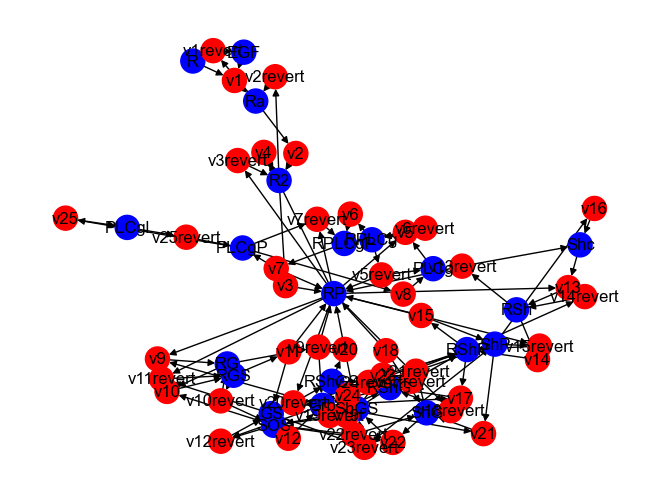

In [11]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [12]:
description_path = 'description_reaction1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

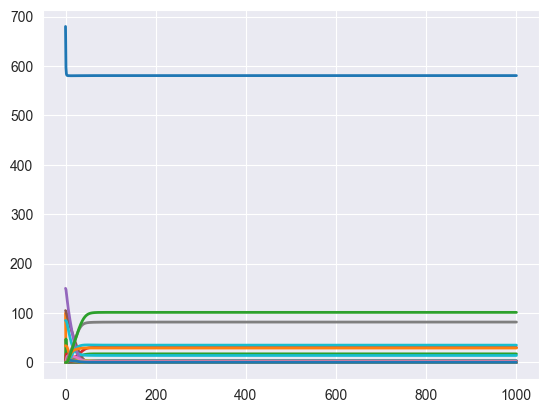

       time,   [EGF],      [R],    [Ra],    [R2],     [RP],   [PLCg],   [RPLCg], [RPLCgP],   [PLCgP],   [Grb],      [RG],   [SOS],      [RGS],     [GS],   [Shc],     [RSh],  [RShP],     [ShP],    [RShG],      [ShG],    [RShGS],     [ShGS],    [PLCgl]
 [[       0,     680,      100,       0,       0,        0,      105,         0,        0,         0,      85,         0,      34,          0,        0,     150,         0,       0,         0,         0,          0,          0,          0,          0],
  [   1.001,  596.57,    16.57, 47.4538, 13.8671, 0.507374,  103.807,  0.934632, 0.242906, 0.0130044, 84.5724, 0.0458333, 33.7027, 0.00423823, 0.286316, 147.507,  0.843805, 1.45991, 0.0985492, 0.0768783, 0.00757042, 0.00539079, 0.00134105, 0.00221992],
  [   2.002, 583.881,  3.88115, 32.0524, 17.2624, 0.775801,   100.03,   2.81658,  1.85741,  0.208349, 83.0338,  0.176215, 33.1954,  0.0406178, 0.549478, 139.472,   1.50721, 6.65235,   1.16835,  0.806474,   0.178961,   0.138136,  0.0763595,  0.

In [13]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000048.xml')

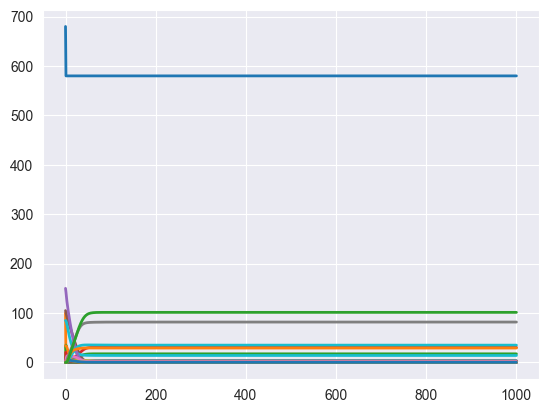

       time,   [EGF],         [R],    [Ra],    [R2],     [RP],   [PLCg],   [RPLCg], [RPLCgP],   [PLCgP],   [Grb],     [RG],   [SOS],     [RGS],     [GS],   [Shc],     [RSh],  [RShP],   [ShP],   [RShG],     [ShG],   [RShGS],   [ShGS],   [PLCgl]
 [[       0,     680,         100,       0,       0,        0,      105,         0,        0,         0,      85,        0,      34,         0,        0,     150,         0,       0,       0,        0,         0,         0,        0,         0],
  [   1.001, 580.001,  0.00121352, 35.1804, 20.8498, 0.863161,  101.377,   2.50976,  1.02105, 0.0746243, 84.0838, 0.136372, 33.6508, 0.0189513, 0.282771, 142.423,    1.6678, 4.92688, 0.50381, 0.379721, 0.0509381, 0.0357244, 0.011763, 0.0172993],
  [   2.002, 580.001, 0.000791299, 22.9435, 16.0245, 0.838733,  96.9111,   3.78887,  3.53672,  0.493505, 81.4027, 0.273436, 32.7748, 0.0859722, 0.531138,  132.77,   1.63911, 10.3447,  2.5396,  1.63562,  0.463039,  0.360201,  0.24792,  0.269771],
  [   3.003, 580.0

In [14]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000048_reaction1_100x.xml')

In [15]:
species = description['species']
species

['EGF',
 'R',
 'Ra',
 'R2',
 'RP',
 'PLCg',
 'RPLCg',
 'RPLCgP',
 'PLCgP',
 'Grb',
 'RG',
 'SOS',
 'RGS',
 'GS',
 'Shc',
 'RSh',
 'RShP',
 'ShP',
 'RShG',
 'ShG',
 'RShGS',
 'ShGS',
 'PLCgl']

In [16]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [17]:
final_normal

[1.00000000e+03 5.80599796e+02 5.99795918e-01 1.74120694e+01
 3.03180163e+01 3.60741476e+00 1.78387154e-01 4.54229304e-02
 3.17930599e-01 3.04247356e+00 1.41682417e+01 3.06958504e+00
 1.77995938e+00 9.13071753e-01 1.69644603e+00 1.15078848e+00
 7.33096786e-02 1.83700763e+00 8.17862387e+01 4.76574477e-01
 3.50655582e+01 3.35734138e-01 2.92747887e+01 1.01415786e+02]

In [18]:
temp = final_concentrations_normal[1]
temp

[680. 100.   0.   0.   0. 105.   0.   0.   0.  85.   0.  34.   0.   0.
 150.   0.   0.   0.   0.   0.   0.   0.   0.]

In [19]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

EGF
final normal:  580.599795917785 final altered:  580.000602440313 delta:  -0.5991934774719994 relative delta  -0.0010320249536512882 initial concentration:  680.0 delta1 0.0008811668786352932 delta2 0.0010320249536512893
R
final normal:  0.5997959177827454 final altered:  0.0006024403131018151 delta:  -0.5991934774696436 relative delta  -0.9989955911748635 initial concentration:  100.0 delta1 0.0059919347746964354 delta2 0.9989955911748636
Ra
final normal:  17.412069399564867 final altered:  17.47078722666854 delta:  0.058717827103674125 relative delta  0.003372248625722885 initial concentration:  0.0 delta1 0 delta2 0.003372248625722829
R2
final normal:  30.318016326850078 final altered:  30.52284062643741 delta:  0.20482429958733306 relative delta  0.006755860851157919 initial concentration:  0.0 delta1 0 delta2 0.00675586085115798
RP
final normal:  3.6074147637684906 final altered:  3.633554753728144 delta:  0.026139989959653498 relative delta  0.0072461836720838614 initial conce

In [20]:
expected_results

{'EGF': 'unchanged',
 'R': 'decreased',
 'Ra': 'unchanged',
 'R2': 'unchanged',
 'RP': 'unchanged',
 'PLCg': 'unchanged',
 'RPLCg': 'unchanged',
 'RPLCgP': 'unchanged',
 'PLCgP': 'unchanged',
 'Grb': 'unchanged',
 'RG': 'unchanged',
 'SOS': 'unchanged',
 'RGS': 'unchanged',
 'GS': 'unchanged',
 'Shc': 'unchanged',
 'RSh': 'unchanged',
 'RShP': 'unchanged',
 'ShP': 'unchanged',
 'RShG': 'unchanged',
 'ShG': 'unchanged',
 'RShGS': 'unchanged',
 'ShGS': 'unchanged',
 'PLCgl': 'unchanged'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

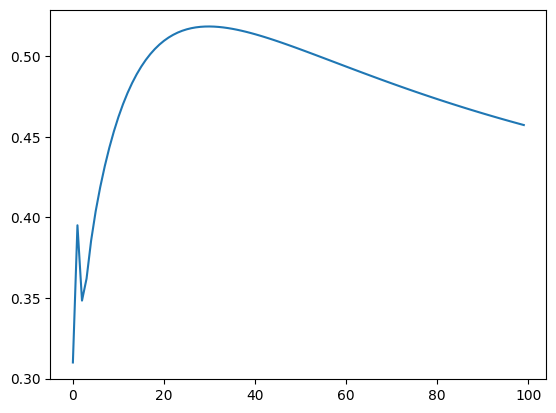

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [21]:
res = complete_tests.complete_tests2(
            'BIOMD0000000048.xml',
            'BIOMD0000000048_reaction1_100x.xml',
            'description_reaction1_altered',
            []
        )

In [22]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  EGF expected result:  decreased
confidence interval:  [0.409292143273189, 0.41347215843377266]
Specie:  R expected result:  decreased
confidence interval:  [0.409292143273189, 0.41347215843377266]
Specie:  Ra expected result:  increased
confidence interval:  [0.6061208316307295, 0.6085289041801097]
Specie:  R2 expected result:  increased
confidence interval:  [0.6241334894421996, 0.6294320291939678]
Specie:  RP expected result:  increased
confidence interval:  [0.5823742124584365, 0.5877564835745356]
Specie:  PLCg expected result:  decreased
confidence interval:  [0.42587562208706453, 0.43147379598674396]
Specie:  RPLCg expected result:  increased
confidence interval:  [0.5193309270818658, 0.520732909861455]
Specie:  RPLCgP expected result:  increased
confidence interval:  [0.5291838224715127, 0.5312418335440335]
Specie:  PLCgP expected result:  decreased
confidence interval:  [0.48933799315980436, 0.4904258978092794]
Specie:  Grb expected result:  decreased
confidence interva

In [23]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  23 correct experiments:  21 ratio:  0.9130434782608695


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

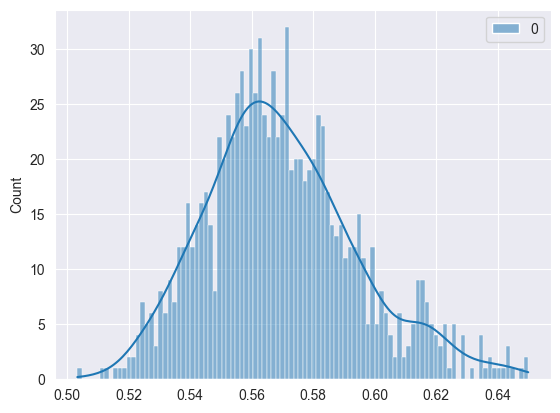

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)